In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from darts.models import ExponentialSmoothing, AutoARIMA
from darts.models.forecasting.prophet_model import Prophet
from darts.metrics.metrics import coefficient_of_variation, mse
from darts import TimeSeries

In [2]:
df = pd.read_csv('C:/Users/lemes/OneDrive/Рабочий стол/dz/T10Y2Y.csv')

In [3]:
df['DATE'] = pd.to_datetime(df['DATE'])

In [4]:
df = df.rename(columns={'T10Y2Y':'percent'})

In [5]:
#бачимо, що замість 0 в наших данних стоїть просто "."
df['percent'].replace('.', 0.0, inplace=True)

In [6]:
df['percent'] = df['percent'].astype('float32')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12346 entries, 0 to 12345
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   DATE     12346 non-null  datetime64[ns]
 1   percent  12346 non-null  float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 144.8 KB


In [8]:
df.describe()

,percent
count,12346.000000
mean,0.848719
std,0.918354
min,-2.410000
25%,0.160000
50%,0.800000
75%,1.480000
max,2.910000


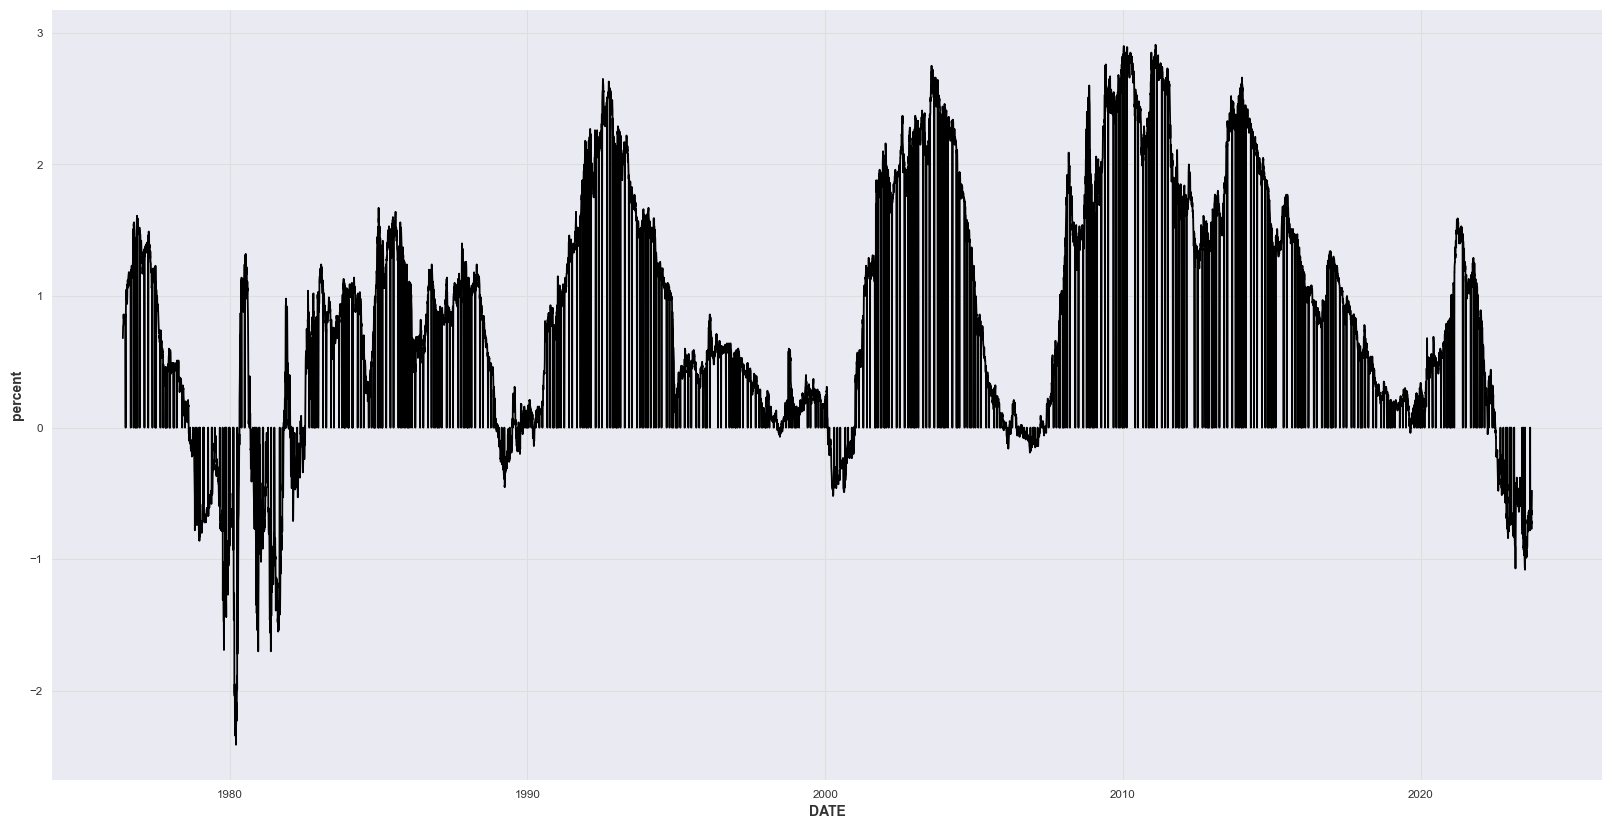

In [9]:
plt.figure(figsize=(20,10))
sns.lineplot(y=df['percent'], x=df['DATE'])
plt.show()

C:\Users\lemes\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


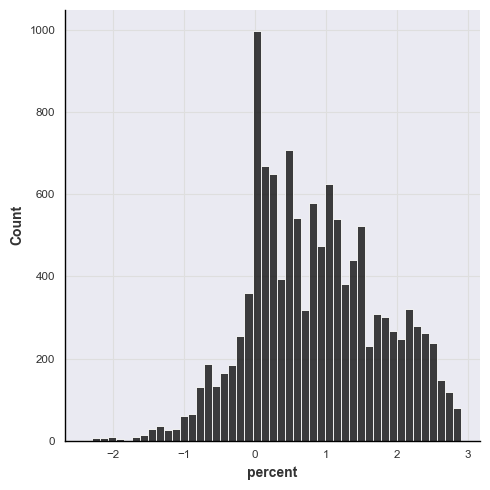

In [10]:
sns.displot(df['percent'])

In [11]:
df.describe()

,percent
count,12346.000000
mean,0.848719
std,0.918354
min,-2.410000
25%,0.160000
50%,0.800000
75%,1.480000
max,2.910000


In [12]:
ts = TimeSeries.from_dataframe(df, 'DATE')

In [13]:
ts

<TimeSeries (DataArray) (DATE: 12346, component: 1, sample: 1)>
array([[[ 0.68]],

       [[ 0.71]],

       [[ 0.7 ]],

       ...,

       [[-0.66]],

       [[-0.54]],

       [[-0.48]]], dtype=float32)
Coordinates:
  * DATE       (DATE) datetime64[ns] 1976-06-01 1976-06-02 ... 2023-09-26
  * component  (component) object 'percent'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [14]:
train, test = ts.split_after(pd.Timestamp('2023-09-01'))

In [15]:
train

<TimeSeries (DataArray) (DATE: 12329, component: 1, sample: 1)>
array([[[ 0.68]],

       [[ 0.71]],

       [[ 0.7 ]],

       ...,

       [[-0.78]],

       [[-0.76]],

       [[-0.69]]], dtype=float32)
Coordinates:
  * DATE       (DATE) datetime64[ns] 1976-06-01 1976-06-02 ... 2023-09-01
  * component  (component) object 'percent'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [16]:
test

<TimeSeries (DataArray) (DATE: 17, component: 1, sample: 1)>
array([[[ 0.  ]],

       [[-0.67]],

       [[-0.71]],

       [[-0.67]],

       [[-0.72]],

       [[-0.68]],

       [[-0.71]],

       [[-0.71]],

       [[-0.71]],

       [[-0.69]],

       [[-0.73]],

       [[-0.71]],

       [[-0.77]],

       [[-0.63]],

       [[-0.66]],

       [[-0.54]],

       [[-0.48]]], dtype=float32)
Coordinates:
  * DATE       (DATE) datetime64[ns] 2023-09-04 2023-09-05 ... 2023-09-26
  * component  (component) object 'percent'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [17]:
def models(md):
    model = md.fit(train)
    prediction = model.predict(len(test.time_index))
    metrcov = coefficient_of_variation(test, prediction)
    mp = mse(test, prediction)
    metric = f'cov = {metrcov}\nmse = {mp}'
    return {'prediction':prediction, 'metric':metric}

In [18]:
def see_actual_data(pred):
    fig, ax = plt.subplots(figsize=(10, 6))
    test.plot(label='Як себе поводить', ax=ax)
    pred.plot(label='Те що предсказала модель', ax=ax)
    ax.legend()
    ax.set_title('Порівнянння реальних показників та вирахуванних даних')

In [19]:
before, after = train.split_after(pd.Timestamp('2023-01-01'))

In [20]:
after

<TimeSeries (DataArray) (DATE: 175, component: 1, sample: 1)>
array([[[ 0.  ]],

       [[-0.61]],

       [[-0.67]],

       [[-0.74]],

       [[-0.69]],

       [[-0.66]],

       [[-0.63]],

       [[-0.66]],

       [[-0.69]],

       [[-0.73]],

...

       [[-0.63]],

       [[-0.68]],

       [[-0.76]],

       [[-0.75]],

       [[-0.78]],

       [[-0.78]],

       [[-0.75]],

       [[-0.78]],

       [[-0.76]],

       [[-0.69]]], dtype=float32)
Coordinates:
  * DATE       (DATE) datetime64[ns] 2023-01-02 2023-01-03 ... 2023-09-01
  * component  (component) object 'percent'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [21]:
def see_data_fut(pred):
    fig, ax = plt.subplots(figsize=(10, 6))
    after.plot(label='Як себе поводить', ax=ax)
    pred.plot(label='Те що предсказала модель', ax=ax)
    ax.legend()
    ax.set_title('Продовження наших данних предказанними')

In [22]:
autoarima = models(md=AutoARIMA())

In [23]:
print(autoarima['metric'])

cov = -31.831725453263857
mse = 0.04081928874678625


Подивимось як це виглядає на графіку

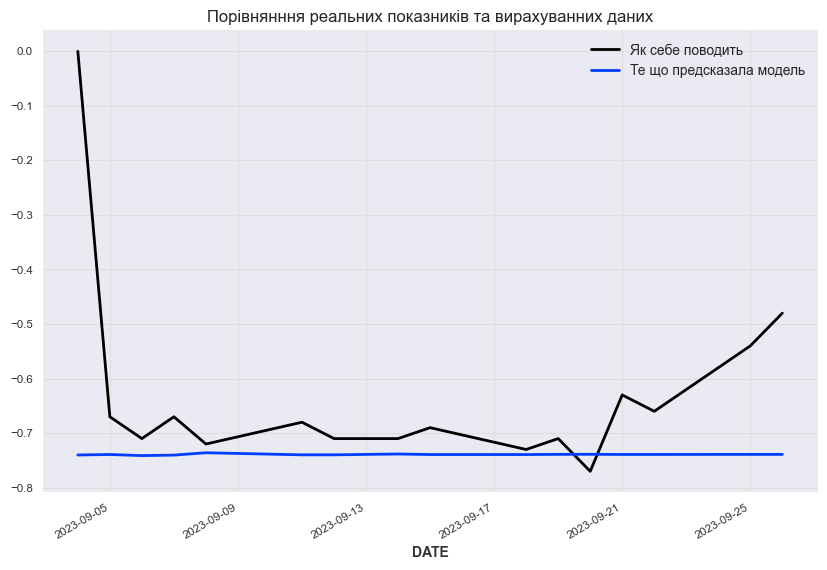

In [24]:
see_actual_data(autoarima['prediction'])

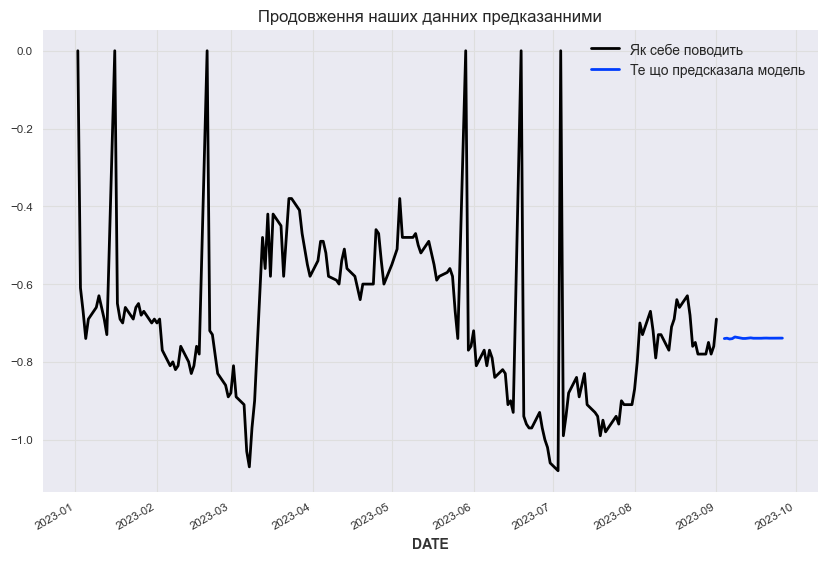

In [25]:
see_data_fut(autoarima['prediction'])

На мій погляд зі совєю функцією - вказання лінії тренду модель впоралась

In [26]:
# подивимось на інші моделі
es = models(ExponentialSmoothing(damped=False, seasonal_periods=None))

In [27]:
print(es['metric'])

cov = -34.856954772569885
mse = 0.04894676100655864


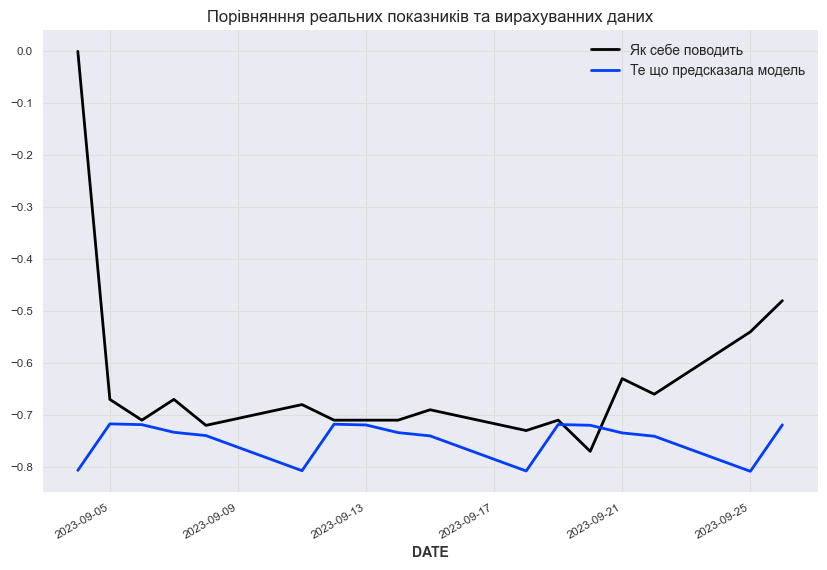

In [28]:
see_actual_data(es['prediction'])

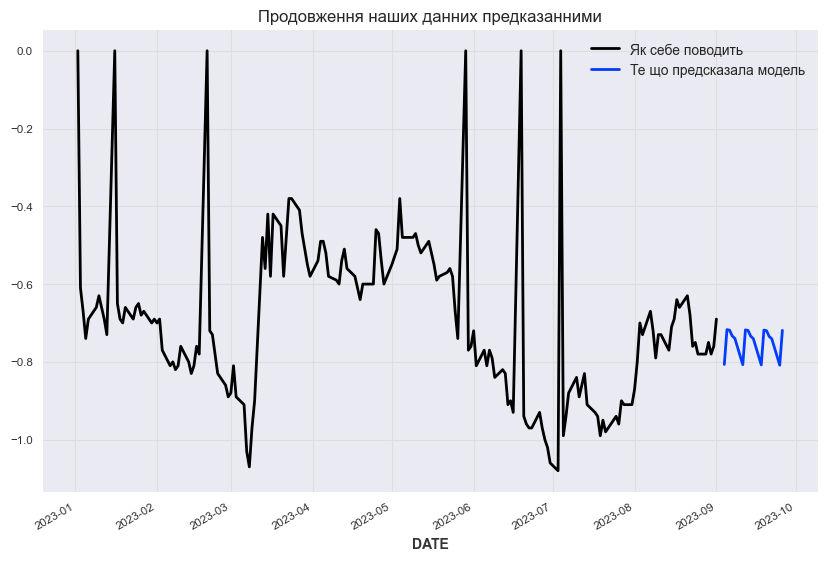

In [29]:
see_data_fut(es['prediction'])

In [30]:
prop = models(Prophet(country_holidays='US'))

18:32:46 - cmdstanpy - INFO - Chain [1] start processing
18:32:54 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
print(prop['metric'])

cov = -78.12128414523735
mse = 0.24585770278863256


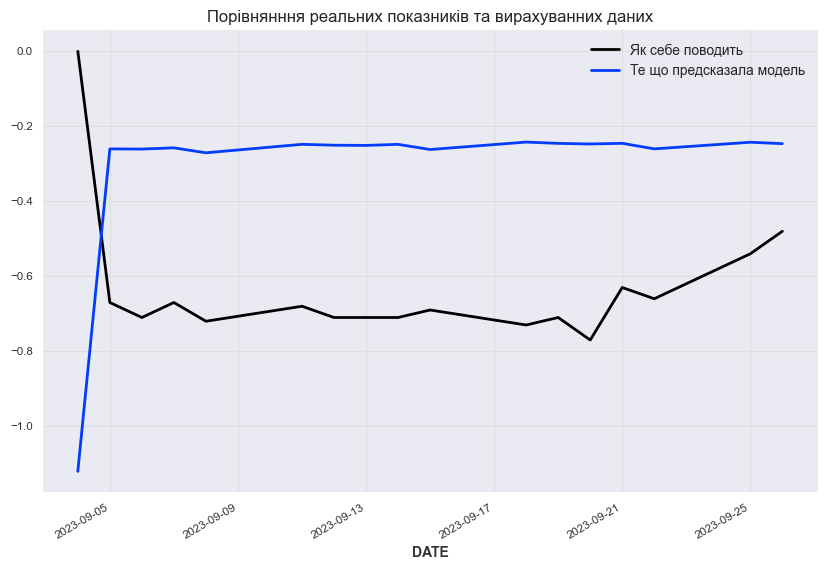

In [32]:
see_actual_data(prop['prediction'])

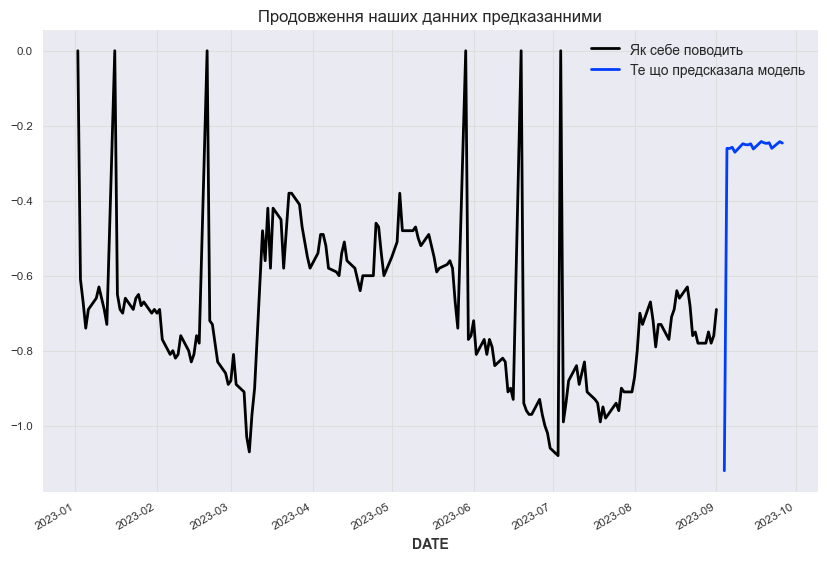

In [33]:
see_data_fut(prop['prediction'])

Цікаво як себе поведуть моделі у прогнозуванні не місяція а 2-3 місяців

In [34]:
train, test = ts.split_after(pd.Timestamp('2023-06-01'))

In [35]:
before, after = train.split_after(pd.Timestamp('2023-01-01'))

In [36]:
es = models(ExponentialSmoothing(damped=False, seasonal_periods=5))

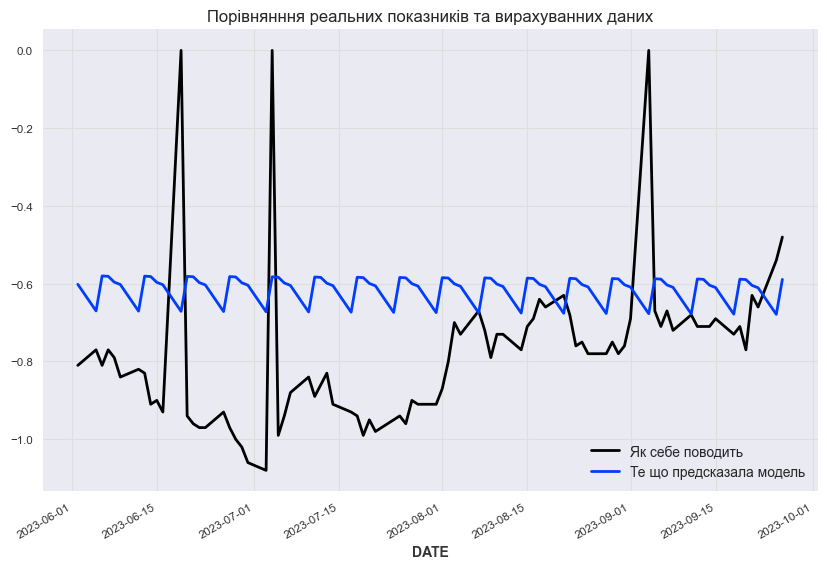

In [37]:
see_actual_data(es['prediction'])

In [38]:
from darts.utils.statistics import  check_seasonality
check_seasonality(ts)

(True, 5)

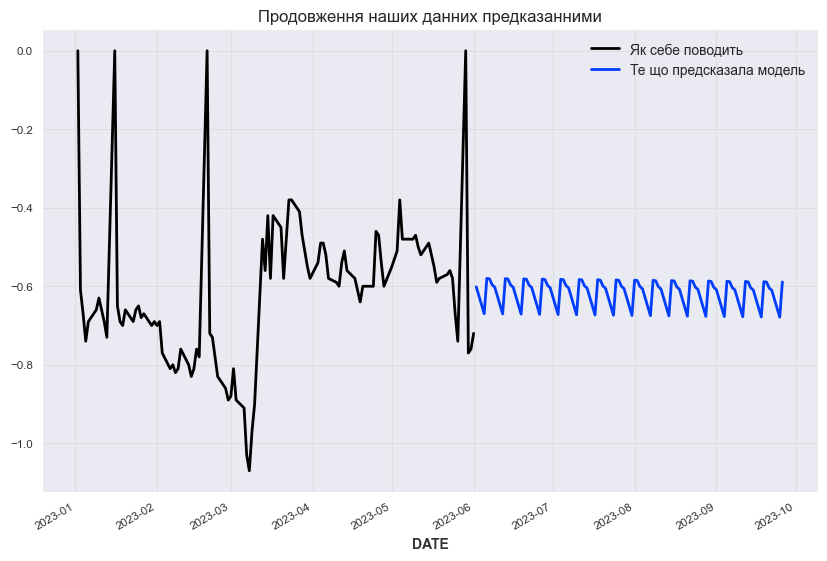

In [39]:
see_data_fut(es['prediction'])

In [40]:
prop = models(Prophet(country_holidays='XNYS'))

18:33:02 - cmdstanpy - INFO - Chain [1] start processing
18:33:14 - cmdstanpy - INFO - Chain [1] done processing


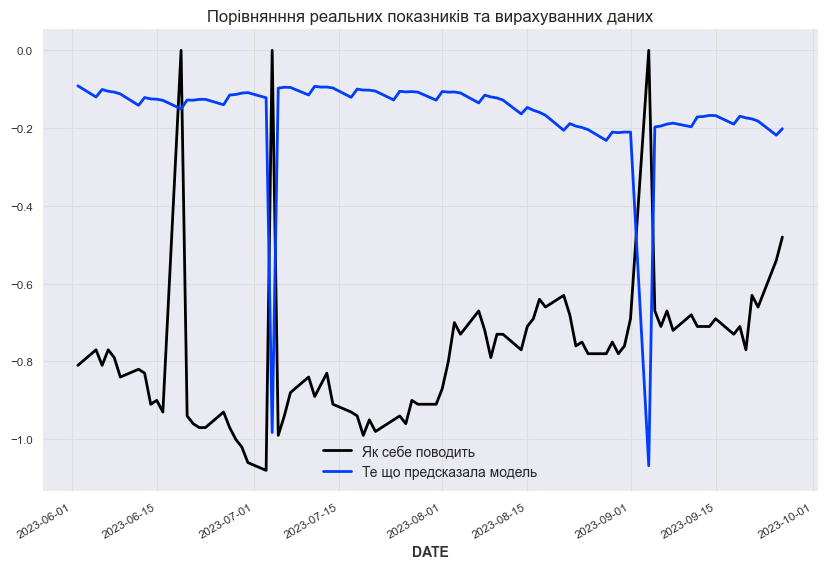

In [41]:
see_actual_data(prop['prediction'])

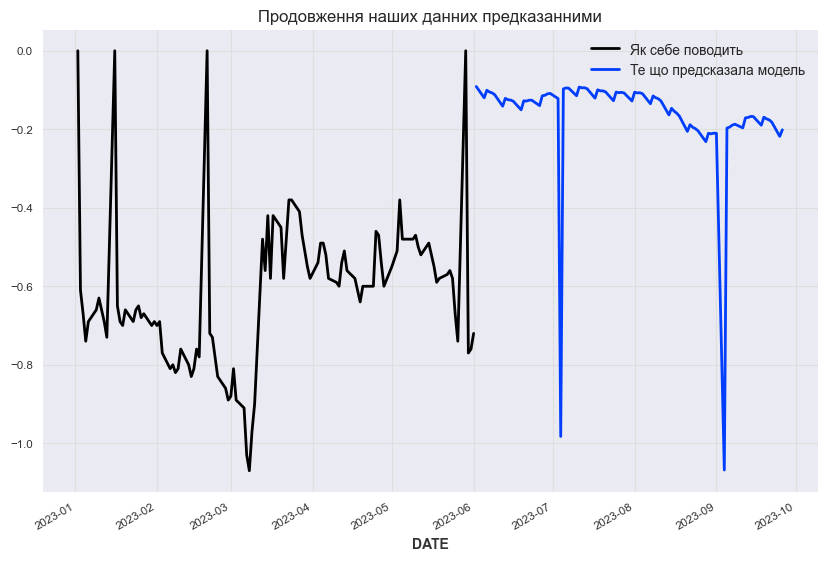

In [42]:
see_data_fut(prop['prediction'])

За базу я би обрав модель ExponentialSmoothing. Хоч вона і не реагує на великі скачки у вихідні дні, але все жтаки краще і ближче описує наші дані за Prophet (але вун дуже цікаво реагує на вихідні дні)